In [ ]:
import h5py

column_count = 729
record_count = 24516
filename = "ceers.hdf5"
with h5py.File(filename, "r") as f:
    # データセットのキーを取得
    keys = list(f.keys())
    print("Column Count:", len(keys))
    print("Keys in the HDF5 file:", keys)

ceers_file = h5py.File(filename, "r")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
for i,b in enumerate(ceers_file):
    # get preffix "image_" column
    if b.endswith('_image'):
        print(b)
        continue
    if b.startswith('image_'):
        print(b)
        continue

In [ ]:
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class ArchivedHDF5Dataset(Dataset):
    def __init__(self, file_path, keys, transform=None):
        self.file_path = file_path
        self.keys = keys
        self.transform = transform
        self.band_le = LabelEncoder()
        with h5py.File(self.file_path, 'r') as f:
            all_bands = []
            self.dataset_len = len(f[self.keys[0]])
            # 全てのキーの長さが同じであることを確認
            for key in keys:
                assert len(f[key]) == self.dataset_len, "All keys must have the same length."
            for i in range(self.dataset_len):
                for band in f['image_band'][i]:
                    all_bands.append(band.decode('utf-8'))
            self.band_le.fit(all_bands)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, index):
        data = {}
        with h5py.File(self.file_path, 'r') as f: # __getitem__ 内でファイルを開く
            for key in self.keys:
                value = f[key][index][()]
                # output image band value
                if key == "image_band":
                    data[key] = torch.from_numpy(self.band_le.transform(value)).long()
                elif isinstance(value, np.ndarray):
                    data[key] = torch.from_numpy(value).float()
                elif isinstance(value, (np.float16, np.float32, np.float64)):
                    data[key] = torch.tensor(value).float()
                elif isinstance(value, list): # リストの場合、ndarrayに変換
                    data[key] = torch.from_numpy(np.array(value)).float()
                # check unsupported type
                elif isinstance(value, (str, bytes)):
                    raise TypeError(f"Unsupported type for key {key}: {type(value)}")
                else:
                    data[key] = torch.tensor(value)
        return data

In [ ]:
from torch.utils.data import DataLoader
keys = [
    'a_image', 
    'b_image', 
    'cxx_image', 
    'cxy_image', 
    'cyy_image', 
    'image_band', 
    'image_flux',
    'image_ivar', 
    'image_mask', 
    'image_psf_fwhm', 
    'image_scale', 
    'theta_image', 
    'x2_image', 
    'x_image', 
    'xy_image', 
    'y2_image', 
    'y_image'
]
dataset = ArchivedHDF5Dataset("ceers.hdf5", keys, keys)
print(dataset.keys)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
# for batch in dataloader:
#     print(batch)
#     break




In [ ]:
import matplotlib.pyplot as plt

# DataLoader から 1 バッチ取得
for batch in dataloader:
    x_image = batch['x_image'].numpy()  # 必要に応じて Tensor を numpy に変換
    y_image = batch['y_image'].numpy()
    break  # 最初のバッチのみ使用

# 天体の位置をプロット
plt.scatter(x_image, y_image, alpha=0.5)
plt.xlabel('x_image')
plt.ylabel('y_image')
plt.title('Astronomical Object Positions')
plt.show()

# データの可視化
1. 天体の基本的な特性の分布:
- mag_auto (自動等級) のヒストグラムを作成し、天体の明るさの分布を可視化してください。
- area_auto (自動面積) のヒストグラムを作成し、天体のサイズの分布を可視化してください。
- 既知の赤方偏移 z_spec がある天体について、赤方偏移のヒストグラムを作成し、宇宙のどのくらいの距離の天体が観測されているかを確認してください。
2. 異なるフィルター間の関係性 (色-色図):
- 例えば、f115w_flux_aper_1 と f150w_flux_aper_1 のフラックスを使って、色 (f115w - f150w) を計算します。同様に、別のフィルターペア（例: f150w と f200w）でも色を計算します。
- これらの2つの色を軸とした散布図（色-色図）を作成し、天体の分布を調べてください。異なる種類の天体は異なる領域に分布する可能性があります。
3. 天体の空間分布:
- ra (赤経) と dec (赤緯) を用いて、観測された天体の空における分布を散布図で可視化してください。分布に偏りがあるかなどを確認できます。
4. 物理量間の関係性:
- mag_auto (等級) と area_auto (面積) の散布図を作成し、明るい天体と暗い天体のサイズに違いがあるかなどを調べてください。
- 既知の赤方偏移 z_spec がある天体について、z_spec と mag_auto の散布図を作成し、遠い天体ほど暗く見える傾向があるかなどを確認してください。

In [ ]:
from torch.utils.data import DataLoader
keys = [
    'z_spec',
]
dataset = ArchivedHDF5Dataset("ceers.hdf5", keys, keys)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
# z_specの値を取得
for batch in dataloader:
    z_spec = batch['z_spec'].numpy()  # 必要に応じて Tensor を numpy に変換
    break

print(z_spec[0:10])

In [ ]:
from torch.utils.data import DataLoader
keys = [
    'mag_auto',
    'area_auto',
    'z_spec',
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'f200w_flux_aper_1'
]
dataset = HDF5Dataset("ceers.hdf5", keys, keys)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
# Draw histogram
import matplotlib.pyplot as plt
import numpy as np
# DataLoader から 1 バッチ取得
for batch in dataloader:
    mag_auto = batch['mag_auto'].numpy()  # 必要に応じて Tensor を numpy に変換
    area_auto = batch['area_auto'].numpy() # 必要に応じて Tensor を numpy に変換
    z_spec = batch['z_spec'].numpy() # 必要に応じて Tensor を numpy に変換
    f115w_flux_aper_1 = batch['f115w_flux_aper_1'].numpy() # 必要に応じて Tensor を numpy に変換
    f150w_flux_aper_1 = batch['f150w_flux_aper_1'].numpy() # 必要に応じて Tensor を numpy に変換
    f200w_flux_aper_1 = batch['f200w_flux_aper_1'].numpy() # 必要に応じて Tensor を numpy に変換
    break  # 最初のバッチのみ使用
# Draw histogram Magnitude
# MEMO: このヒストグラムから、最も頻繁に見られる等級や、明るい天体と暗い天体の数の比率などを読み取ることができます。
plt.hist(mag_auto, bins=150, alpha=1)
plt.xlabel('Magnitude')
plt.ylabel('Number of Objects')
plt.title('Distribution of Automatic Magnitude (mag_auto)')
plt.grid()
plt.show()
# Draw histogram Area
# MEMO: このヒストグラムから、小さな天体が多いのか、大きな天体も一定数存在するのかなどを確認できます。面積の分布は対数正規分布のような形状になることが多いです。
plt.hist(area_auto, bins=150, alpha=1)
plt.xlabel('Area')
plt.ylabel('Number of Objects')
plt.title('Distribution of Area (area_auto)')
plt.grid()
plt.show()
# Draw histogram Redshift -> 欠損値が多いため、ヒストグラムの形状が不明瞭。
# MEMO: このヒストグラムから、赤方偏移の分布を確認できます。特に、遠くの天体ほど赤方偏移が大きくなる傾向があります。
# plt.hist(z_spec, bins=150, alpha=0.7)
# plt.xlabel('Redshift (z_spec)')
# plt.ylabel('Number of Objects')
# plt.title('Distribution of Redshift (z_spec)')
# plt.grid()
# plt.show()
# Draw histogram f115w_flux_aper_1
# MEMO: このヒストグラムから、フラックスの分布を確認できます。特に、明るい天体ほどフラックスが大きくなる傾向があります。
plt.hist(f115w_flux_aper_1, bins=150, alpha=1)
plt.xlabel('Flux (f115w_flux_aper_1)')
plt.ylabel('Number of Objects')
plt.title('Distribution of Flux (f115w_flux_aper_1)')
plt.grid()
plt.show()
# Draw histogram f200w_flux_aper_1
# MEMO: このヒストグラムから、フラックスの分布を確認できます。特に、明るい天体ほどフラックスが大きくなる傾向があります。
plt.hist(f200w_flux_aper_1, bins=150, alpha=1)
plt.xlabel('Flux (f200w_flux_aper_1)')
plt.ylabel('Number of Objects')
plt.title('Distribution of Flux (f200w_flux_aper_1)')
plt.grid()
plt.show()
# 色の分布 (等級を用いた例)
# MEMO: このヒストグラムから、色の分布を確認できます。特に、赤方偏移や星の進化段階に応じて色が変化することがあります。
mag1 = -2.5 * np.log10(f115w_flux_aper_1)
mag2 = -2.5 * np.log10(f150w_flux_aper_1)
plt.scatter(mag1, mag2, alpha=0.5)
plt.xlabel('Magnitude Difference ({filter1_flux_col.split("_")[0]} - {filter2_flux_col.split("_")[0]})')
plt.ylabel('Number of Objects')
plt.title('Distribution of Color ({filter1_flux_col.split("_")[0]} - {filter2_flux_col.split("_")[0]})')
plt.grid()
plt.show()


# 機械学習モデルの作成と推論
1. 回帰問題: 特定のフィルターのフラックス予測:

- 目的変数: 例えば、f200w_flux_aper_1 (F200Wフィルターのフラックス)
- 説明変数: 他のフィルターのフラックス（例: f115w_flux_aper_1, f150w_flux_aper_1 など）や天体の形状パラメータ (a_image, b_image など）
- モデル: 線形回帰、決定木、ランダムフォレストなど
- 推論: 学習済みモデルを使って、新しい天体の他のフィルターのフラックスから f200w_flux_aper_1 を予測してみてください。

2. 分類問題: 天体の種類を予測 (簡略化):

- 特徴量: 異なるフィルターのフラックスの色情報（上記の色-色図で作成したような特徴量）
- ラベル (簡略化): 例えば、特定の色の範囲にある天体を「タイプA」、別の範囲にある天体を「タイプB」のように人為的にラベル付けします。
- モデル: ロジスティック回帰、サポートベクターマシン、決定木など
- 推論: 学習済みモデルを使って、新しい天体の色情報から「タイプ」を予測してみてください。

3. クラスタリング: 天体のグループ分け:
- 特徴量: 複数のフィルターのフラックス、形状パラメータ、等級など
- アルゴリズム: K-means、階層的クラスタリングなど
- 推論: 学習済みモデル（クラスタリングの場合は、データのグループ分け）を使って、新しい天体がどのグループに属するかを調べてください。可視化と組み合わせて、各グループの天体の特徴を分析すると面白いでしょう。

## メインプロセスのみ

In [ ]:
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class HDF5Dataset(Dataset):
    def __init__(self, file_path, keys, transform=None):
        self.file_path = file_path
        self.keys = keys
        self.transform = transform
        self.band_le = LabelEncoder()
        self.h5_file = h5py.File(self.file_path, 'r')
        self.dataset_len = len(self.h5_file[self.keys[0]])

        # 全てのキーの長さが同じであることを確認
        for key in keys:
            assert len(self.h5_file[key]) == self.dataset_len, "All keys must have the same length."

        all_bands = []
        for i in range(self.dataset_len):
            for band in self.h5_file['image_band'][i]:
                all_bands.append(band.decode('utf-8'))
        self.band_le.fit(all_bands)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, index):
        data = {}
        for key in self.keys:
            value = self.h5_file[key][index][()]
            if key == "image_band":
                data[key] = torch.from_numpy(self.band_le.transform(value)).long()
            elif isinstance(value, np.ndarray):
                data[key] = torch.from_numpy(value).float()
            elif isinstance(value, (np.float16, np.float32, np.float64)):
                data[key] = torch.tensor(value).float()
            elif isinstance(value, list):
                data[key] = torch.from_numpy(np.array(value)).float()
            elif isinstance(value, (str, bytes)):
                raise TypeError(f"Unsupported type for key {key}: {type(value)}")
            else:
                data[key] = torch.tensor(value)
        return data

    def __del__(self):
        if hasattr(self, 'h5_file') and self.h5_file:
            self.h5_file.close()

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import multiprocessing


# Check that MPS is available (Apple Silicon GPU を利用可能か確認)
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    mps_device = torch.device("mps")
# 特徴量として使用する列名
features = [
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'mag_auto',
    'a_image',
    'b_image',
    'peak'
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# データセットの読み込み
dataset = HDF5Dataset("ceers.hdf5", features + [target], features + [target])
# DataLoader を使用して、データセットからバッチごとにデータを取り出す (この例ではデータセット全体を1つのバッチとしてロード)
cpu_count = multiprocessing.cpu_count()
print("CPU Count:", cpu_count)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=len(dataset), 
    shuffle=True,
)
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}  # 必要に応じて Tensor を numpy に変換
    break  # 最初のバッチのみ使用
# DataFrameに変換
df = pd.DataFrame(data)
# 欠損値の処理 (NaN を含む行をデータセットから削除)
df = df.dropna()
# 特徴量とターゲットに分割 (モデルの入力となる特徴量と予測したいターゲット変数を分離)
X = df[features].values
y = df[target].values
# データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

import torch.nn as nn
# 入力特徴量の数 (モデルの入力層のノード数を決定)
input_size = X_train.shape[1]
# 出力変数の数 (モデルの出力層のノード数を決定。ここでは1つの値を予測)
output_size = 1
# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)
# モデルのインスタンスを作成 (定義したモデルクラスのオブジェクトを作成)
model = LinearRegressionModel(input_size, output_size)

# モデルのパラメータ数を表示 (モデルの複雑さを確認)
num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')
# モデルの概要を表示 (モデルの構造を確認)
print(model)

# 損失関数の定義 (回帰問題では平均二乗誤差 (MSE) を使用)
criterion = nn.MSELoss()

# 最適化アルゴリズムの定義 (モデルのパラメータを最適化するためのアルゴリズムを選択。Adam は一般的な選択肢)
learning_rate = 0.01 # 学習率を設定。パラメータの更新幅を制御
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# トレーニングのエポック数 (モデルを学習データで繰り返し学習させる回数)
num_epochs = 1000
losses = [] # 各エポックの損失を記録するためのリスト

# トレーニングループ (指定されたエポック数だけ学習を繰り返す)
for epoch in range(num_epochs):
    # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
    outputs = model(X_train)
    # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
    loss = criterion(outputs, y_train)
    # 逆伝播とパラメータ更新 (backward pass and optimization)
    optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
    loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
    optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

    losses.append(loss.item()) # 現在のエポックの損失値をリストに追加

    # 一定間隔で損失を出力して学習の進捗を確認
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# モデル全体の保存 (学習済みモデルのパラメータをファイルに保存)
torch.save(model.state_dict(), 'linear_regression_model.pth')
print("Model saved as linear_regression_model.pth")

# 学習曲線のプロット (オプション) (エポックごとの損失の推移をグラフで可視化)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### MPS対応

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import multiprocessing
from torch.utils.data import DataLoader

# デバイスの設定 (MPS が利用可能なら使用、そうでなければ CPU を使用)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    device = mps_device
    print("MPS device found and will be used.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU found, CPU will be used.")

# 特徴量として使用する列名
features = [
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'mag_auto',
    'a_image',
    'b_image',
    'peak'
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# データセットの読み込み
dataset = HDF5Dataset("ceers.hdf5", features + [target], features + [target])
# DataLoader を使用して、データセットからバッチごとにデータを取り出す (この例ではデータセット全体を1つのバッチとしてロード)
cpu_count = multiprocessing.cpu_count()
print("CPU Count:", cpu_count)
dataloader = DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True,
)
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}  # 必要に応じて Tensor を numpy に変換
    break  # 最初のバッチのみ使用
# DataFrameに変換
df = pd.DataFrame(data)
# 欠損値の処理 (NaN を含む行をデータセットから削除)
df = df.dropna()
# 特徴量とターゲットに分割 (モデルの入力となる特徴量と予測したいターゲット変数を分離)
X = df[features].values
y = df[target].values
# データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

import torch.nn as nn
# 入力特徴量の数 (モデルの入力層のノード数を決定)
input_size = X_train.shape[1]
# 出力変数の数 (モデルの出力層のノード数を決定。ここでは1つの値を予測)
output_size = 1
# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)
# モデルのインスタンスを作成 (定義したモデルクラスのオブジェクトを作成)
model = LinearRegressionModel(input_size, output_size).to(device)

# モデルのパラメータ数を表示 (モデルの複雑さを確認)
num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')
# モデルの概要を表示 (モデルの構造を確認)
print(model)

# 損失関数の定義 (回帰問題では平均二乗誤差 (MSE) を使用)
criterion = nn.MSELoss()

# 最適化アルゴリズムの定義 (モデルのパラメータを最適化するためのアルゴリズムを選択。Adam は一般的な選択肢)
learning_rate = 0.01 # 学習率を設定。パラメータの更新幅を制御
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# トレーニングのエポック数 (モデルを学習データで繰り返し学習させる回数)
num_epochs = 1000
losses = [] # 各エポックの損失を記録するためのリスト

# トレーニングループ (指定されたエポック数だけ学習を繰り返す)
for epoch in range(num_epochs):
    # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
    outputs = model(X_train)
    # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
    loss = criterion(outputs, y_train)
    # 逆伝播とパラメータ更新 (backward pass and optimization)
    optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
    loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
    optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

    losses.append(loss.item()) # 現在のエポックの損失値をリストに追加

    # 一定間隔で損失を出力して学習の進捗を確認
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# モデル全体の保存 (学習済みモデルのパラメータをファイルに保存)
torch.save(model.state_dict(), 'linear_regression_model.pth')
print("Model saved as linear_regression_model.pth")

# 学習曲線のプロット (オプション) (エポックごとの損失の推移をグラフで可視化)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### EPOCH 増加

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import multiprocessing
from torch.utils.data import DataLoader
import os

# デバイスの設定 (MPS が利用可能なら使用、そうでなければ CPU を使用)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    device = mps_device
    print("MPS device found and will be used.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU found, CPU will be used.")
device = torch.device("cpu")

# 特徴量として使用する列名
features = [
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'mag_auto',
    'a_image',
    'b_image',
    'peak'
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# データセットの読み込み
dataset = HDF5Dataset("ceers.hdf5", features + [target], features + [target])
# DataLoader を使用して、データセットからバッチごとにデータを取り出す (この例ではデータセット全体を1つのバッチとしてロード)
cpu_count = multiprocessing.cpu_count()
print("CPU Count:", cpu_count)
dataloader = DataLoader(
    dataset,
    batch_size=len(dataset),
    shuffle=True,
)
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}  # 必要に応じて Tensor を numpy に変換
    break  # 最初のバッチのみ使用
# DataFrameに変換
df = pd.DataFrame(data)
# 欠損値の処理 (NaN を含む行をデータセットから削除)
df = df.dropna()
# 特徴量とターゲットに分割 (モデルの入力となる特徴量と予測したいターゲット変数を分離)
X = df[features].values
y = df[target].values
# データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# データの確認 (トレーニングデータとテストデータの形状を出力して確認)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

import torch.nn as nn
# 入力特徴量の数 (モデルの入力層のノード数を決定)
input_size = X_train.shape[1]
# 出力変数の数 (モデルの出力層のノード数を決定。ここでは1つの値を予測)
output_size = 1
# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)
# モデルのインスタンスを作成 (定義したモデルクラスのオブジェクトを作成)
model = LinearRegressionModel(input_size, output_size).to(device)

# モデルのパラメータ数を表示 (モデルの複雑さを確認)
num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')
# モデルの概要を表示 (モデルの構造を確認)
print(model)

# 損失関数の定義 (回帰問題では平均二乗誤差 (MSE) を使用)
criterion = nn.MSELoss()

# 最適化アルゴリズムの定義 (モデルのパラメータを最適化するためのアルゴリズムを選択。Adam は一般的な選択肢)
learning_rate = 0.01 # 学習率を設定。パラメータの更新幅を制御
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 目標とする損失値
target_loss = 0.01  # 例：目標とする損失値を設定
losses = [] # 各エポックの損失を記録するためのリスト
epoch = 0
max_epochs = 10000 # 無限ループを防ぐための最大エポック数
best_loss_file = "best_loss.txt"
model_save_path = "linear_regression_model.pth"
best_loss = float('inf')
best_loss_achieved = False

# 既存のベストロスをファイルからロード
if os.path.exists(best_loss_file):
    with open(best_loss_file, 'r') as f:
        try:
            best_loss = float(f.readline())
            print(f"Loaded best loss from file: {best_loss:.4f}")
        except ValueError:
            print("Could not read best loss from file, starting with infinity.")

# トレーニングループ (目標損失に達するか、最大エポック数に達するまで学習を繰り返す)
while True:
    # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
    outputs = model(X_train)
    # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
    loss = criterion(outputs, y_train)
    current_loss = loss.item()

    losses.append(current_loss) # 現在のエポックの損失値をリストに追加

    # 損失が目標値以下になったらループを抜ける
    if current_loss <= target_loss:
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f} (Target loss reached)')
        break

    # 現在の損失が過去最高の損失よりも小さい場合にモデルを保存し、ベストロスを更新
    if current_loss < best_loss:
        best_loss = current_loss
        torch.save(model.state_dict(), model_save_path)
        with open(best_loss_file, 'w') as f:
            f.write(str(best_loss))
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f} (Best loss so far, model saved)')
        best_loss_achieved = True

    # 逆伝播とパラメータ更新 (backward pass and optimization)
    optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
    loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
    optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

    # 一定間隔で損失を出力して学習の進捗を確認
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f}')

    epoch += 1

    # 最大エポック数を超えた場合はループを抜ける (過学習を防ぐためにも重要)
    if epoch >= max_epochs:
        print(f'Epoch [{epoch+1}], Loss: {current_loss:.4f} (Max epochs reached)')
        break

print(f"Training finished. Best loss achieved: {best_loss:.4f}")

# max_epochs に達したが best_loss が更新されなかった場合のメッセージ
if epoch >= max_epochs and not best_loss_achieved:
    print("Maximum epochs reached, but no improvement in best loss. Model not saved (or the initial best loss remains).")
elif best_loss_achieved:
    print(f"Model with best loss saved to {model_save_path}")
else:
    # 目標損失に達した場合
    print(f"Model saved to {model_save_path}") # 目標損失に達した場合も保存されているのでメッセージを表示

# モデルを評価モードにする (不要な勾配計算などを抑制)
# モデルを評価モードに設定します。これにより、バッチノーマライゼーションやドロップアウトなどの層が評価モードで動作するようになります
model.eval()
# このブロック内の計算では勾配が計算されません。評価時には不要なため、メモリ使用量を減らし、計算を高速化できます。
with torch.no_grad():
    test_outputs = model(X_test)
    predicted_values = test_outputs.cpu().numpy()
    true_values = y_test.cpu().numpy()

# 予測値 vs. 真値の散布図
# あなたのモデルがテストデータに対して行った予測値と、そのテストデータの実際の正解の値（真値）を比較するためのもの
# 横軸 (True Values): テストデータにおけるターゲット変数（今回の場合は area_auto）の実際の値を示しています
# 縦軸 (Predicted Values): あなたのモデルが同じテストデータに対して予測した area_auto の値を示しています。
# 理想的な結果: もしモデルが完璧であれば、全ての点は左下から右上に向かう対角線上に並びます。この対角線は「予測値 = 真値」を表しています。
plt.figure(figsize=(8, 8))
plt.scatter(true_values, predicted_values)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2) # 理想的な対角線
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()

# 残差プロット
# この図は、モデルの予測誤差（残差）がどのように分布しているかを見るためのものです。残差は「予測値 - 真値」で計算されます。
# 横軸 (Predicted Values): モデルが予測した値を示しています。
# 縦軸 (Residuals): 残差を示しています。残差は「予測値 - 真値」で計算されます。
# 残差が 0 のライン (赤い破線): 理想的な場合、残差は 0 であるべきです。このラインは、モデルが完璧に予測した場合の残差を示しています。
residuals = predicted_values - true_values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--') # 残差が 0 のライン
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - True)')
plt.title('Residual Plot')
plt.show()

# 学習曲線のプロット (オプション) (エポックごとの損失の推移をグラフで可視化)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Ray Tune

In [ ]:
current_loss

2025-04-13 16:34:38,056	ERROR tune_controller.py:1331 -- Trial task failed for trial train_tune_b7233_00002
Traceback (most recent call last):
  File "/Users/tozastation/ghq/github.com/tozastation/try-astronomy/photometric-redshift-estimation/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/tozastation/ghq/github.com/tozastation/try-astronomy/photometric-redshift-estimation/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/tozastation/ghq/github.com/tozastation/try-astronomy/photometric-redshift-estimation/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/tozastation/ghq/github.com/tozastation/try-astronomy/photometric-redshift-estimation/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 

RuntimeError: No best trial found for the given metric: best_loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

2025-04-13 17:29:17,822	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/tozastation/ray_results/linear_regression_tune' in 0.0917s.
2025-04-13 17:29:17,841	INFO tune.py:1041 -- Total run time: 368.02 seconds (367.89 seconds for the tuning loop).


Best Trial: {'loss': 50089552.0, 'epoch': 4999, 'best_loss': 50089552.0, 'timestamp': 1744532814, 'checkpoint_dir_name': None, 'done': True, 'training_iteration': 5000, 'trial_id': '88aac_00057', 'date': '2025-04-13_17-26-54', 'time_this_iter_s': 0.0005540847778320312, 'time_total_s': 16.71312928199768, 'pid': 6608, 'hostname': '3-shake-tozawa.local', 'node_ip': '127.0.0.1', 'config': {'learning_rate': 0.00122545870876565, 'epochs': 5000, 'data_path': '/Users/tozastation/ghq/github.com/tozastation/try-astronomy/photometric-redshift-estimation/ceers.hdf5', 'use_f115w_flux_aper_1': True, 'use_f150w_flux_aper_1': True, 'use_a_image': False, 'use_b_image': True, 'use_peak': False}, 'time_since_restore': 16.71312928199768, 'iterations_since_restore': 5000, 'experiment_tag': '57_epochs=5000,learning_rate=0.0012,use_a_image=False,use_b_image=True,use_f115w_flux_aper_1=True,use_f150w_flux_aper_1=True,use_peak=False'}
Best trial config: {'learning_rate': 0.00122545870876565, 'epochs': 5000, 'da

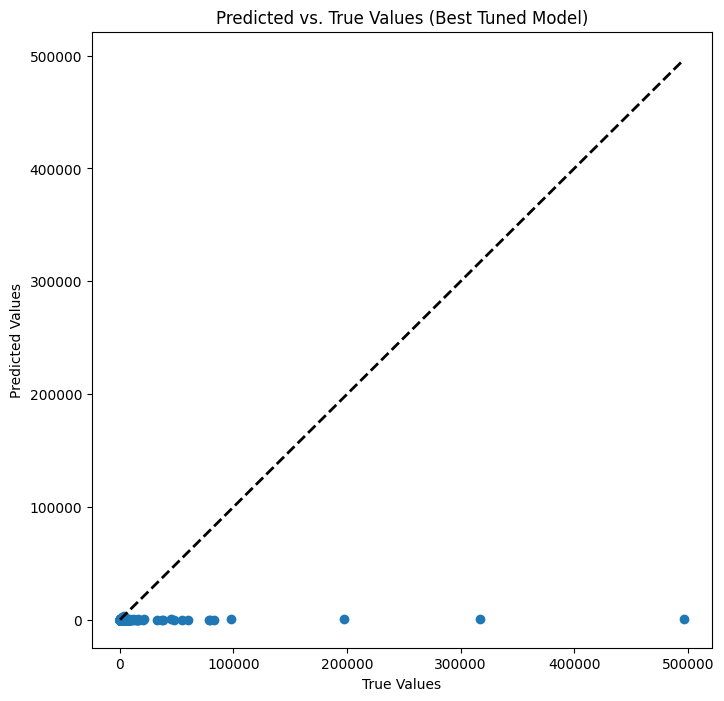

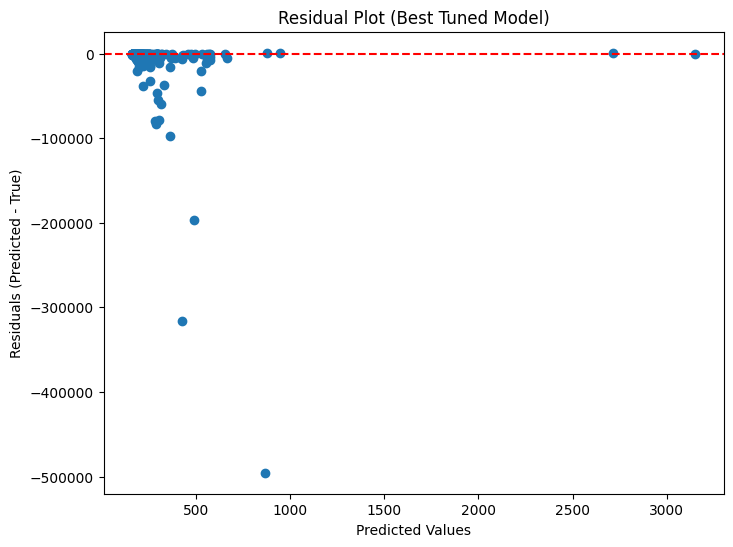

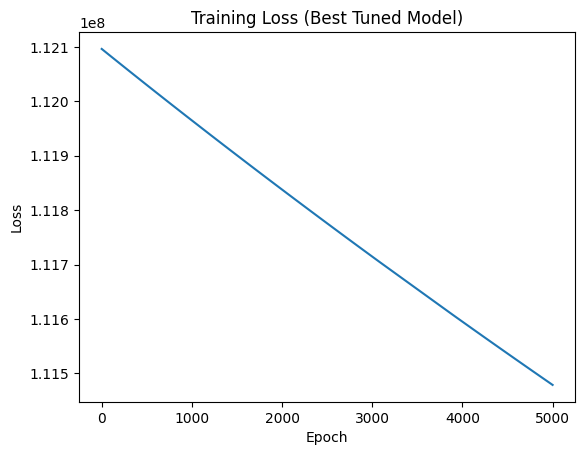

Removed subdirectory in Ray Tune directory: /Users/tozastation/ray_results/linear_regression_tune/train_tune_88aac_00089_89_epochs=100,learning_rate=0.0002,use_a_image=True,use_b_image=False,use_f115w_flux_aper_1=True,use_f150w__2025-04-13_17-23-10
Removed subdirectory in Ray Tune directory: /Users/tozastation/ray_results/linear_regression_tune/train_tune_88aac_00095_95_epochs=5000,learning_rate=0.0654,use_a_image=True,use_b_image=False,use_f115w_flux_aper_1=True,use_f150w_2025-04-13_17-23-10
Removed subdirectory in Ray Tune directory: /Users/tozastation/ray_results/linear_regression_tune/train_tune_88aac_00041_41_epochs=10000,learning_rate=0.0006,use_a_image=True,use_b_image=False,use_f115w_flux_aper_1=False,use_f15_2025-04-13_17-23-10
Removed subdirectory in Ray Tune directory: /Users/tozastation/ray_results/linear_regression_tune/train_tune_88aac_00009_9_epochs=5000,learning_rate=0.0529,use_a_image=True,use_b_image=True,use_f115w_flux_aper_1=True,use_f150w_f_2025-04-13_17-23-10
Remo

In [64]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import shutil
import glob

# Ray Tune のためのインポート
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# デバイスの設定 (Ray Tune の設定で GPU を利用するかどうかを指定できるため、ここでは CPU に固定)
device = torch.device("cpu")
print("Using CPU for Ray Tune.")

# 特徴量として使用する列名
features = [
    'f115w_flux_aper_1',
    'f150w_flux_aper_1',
    'mag_auto',
    'a_image',
    'b_image',
    'peak'
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'

# 線形回帰モデルの定義 (PyTorch の nn.Module を継承してモデルを定義)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # 線形層 (全結合層) を定義。入力サイズと出力サイズを指定
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # 順伝播処理。入力 x を線形層に通して出力を得る
        return self.linear(x)

# Ray Tune で最適化する train 関数
def train_tune(config):
    # データセットの読み込み
    dataset = HDF5Dataset(config["data_path"], features + [target], features + [target])
    dataloader = torch.utils.data.DataLoader( # DataLoader を使用
        dataset,
        batch_size=len(dataset),
        shuffle=True,
    )
    for batch in dataloader:
        data = {key: batch[key].numpy() for key in features + [target]}
        break
    df = pd.DataFrame(data)
    df = df.dropna()
    # config に基づいて使用する特徴量のリストを作成
    selected_features = []
    selected_features.append('mag_auto')
    if config["use_f115w_flux_aper_1"]:
        selected_features.append('f115w_flux_aper_1')
    if config["use_f150w_flux_aper_1"]:
        selected_features.append('f150w_flux_aper_1')
    if config["use_a_image"]:
        selected_features.append('a_image')
    if config["use_b_image"]:
        selected_features.append('b_image')
    if config["use_peak"]:
        selected_features.append('peak')

    X = df[selected_features].values
    y = df[target].values
    # データの分割 (トレーニング用とテスト用データに分割。テストデータはモデルの性能評価に使用)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 分割されたデータのインデックスを保存
    trial_id = tune.get_context().get_trial_id()
    output_dir = tune.get_context().get_trial_dir()
    np.save(os.path.join(output_dir, f"train_indices_{trial_id}.npy"), np.arange(len(X))[np.isin(np.arange(len(X)), np.arange(len(X))[train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)[0]])])
    np.save(os.path.join(output_dir, f"test_indices_{trial_id}.npy"), np.arange(len(X))[np.isin(np.arange(len(X)), np.arange(len(X))[train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)[1]])])

    # データの標準化 (特徴量のスケールを揃えることで、モデルの学習を安定させ、性能を向上させる)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # NumPy 配列を PyTorch の Tensor に変換 (PyTorch のモデルで扱えるようにデータ形式を変換)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

    # モデルのインスタンスを作成 (ハイパーパラメータを使用)
    input_size = X_train.shape[1]
    output_size = 1
    model = LinearRegressionModel(input_size, output_size).to(device)

    # 損失関数とオプティマイザの定義 (ハイパーパラメータを使用)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    best_trial_loss = float('inf')

    # トレーニングループ (ハイパーパラメータを使用)
    for epoch in range(config["epochs"]):
        # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
        outputs = model(X_train)
        # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
        loss = criterion(outputs, y_train)
        current_loss = loss.item()
        # 逆伝播とパラメータ更新 (backward pass and optimization)
        optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
        loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
        optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)

        best_trial_loss = min(best_trial_loss, current_loss)

        # Ray Tune に Loss を報告
        print({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss})
        tune.report({"loss": current_loss, "epoch": epoch, "best_loss": best_trial_loss})

# ハイパーパラメータの探索空間を定義
config = {
    "learning_rate": tune.loguniform(1e-4, 1e-1),
    "epochs": tune.choice([100, 200, 500, 1000, 2000, 5000, 10000]),
    "data_path": "/Users/tozastation/ghq/github.com/tozastation/try-astronomy/photometric-redshift-estimation/ceers.hdf5",
    # 各候補の特徴量を使用するかどうかのフラグ
    "use_f115w_flux_aper_1": tune.choice([True, False]),
    "use_f150w_flux_aper_1": tune.choice([True, False]),
    "use_a_image": tune.choice([True, False]),
    "use_b_image": tune.choice([True, False]),
    "use_peak": tune.choice([True, False]),
}

# スケジューラを設定 (リソースを効率的に利用するために ASHA を使用)
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    reduction_factor=2,
    max_t=10000  # 最大エポック数を設定 (config の最大値に合わせる)
)

trainable_with_resources = tune.with_resources(trainable=train_tune, resources={"cpu": 2, "gpu": 0})

# Ray Tune の実行
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=100,  # サンプル数を指定
    ),
    run_config=tune.RunConfig(
        name="linear_regression_tune",
    )
)
results = tuner.fit()

# ベストなハイパーパラメータを取得
best_trial = results.get_best_result("best_loss", "min", filter_nan_and_inf=False) # best_loss を指標とする
print(f"Best Trial: {best_trial.metrics}")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.metrics['best_loss']:.4f}")

# ベストなハイパーパラメータで最終的なモデルを学習し、best_loss.txt を参照して保存
best_config = best_trial.config
final_criterion = nn.MSELoss()
final_losses = []
final_epochs = best_config["epochs"]
best_loss_file = "best_loss.txt"
model_save_path = "linear_regression_model.pth"
initial_best_loss = float('inf')

# 既存のベストロスをファイルからロード
if os.path.exists(best_loss_file):
    with open(best_loss_file, 'r') as f:
        try:
            initial_best_loss = float(f.readline())
            print(f"Loaded best loss from file: {initial_best_loss:.4f}")
        except ValueError:
            print("Could not read best loss from file, starting with infinity.")

# ベストトライアルのデータ分割をロードして最終学習に使用
best_trial_path = best_trial.path
best_trial_id = best_trial.metrics["trial_id"]
train_indices = np.load(os.path.join(best_trial_path, f"train_indices_{best_trial_id}.npy"))
test_indices = np.load(os.path.join(best_trial_path, f"test_indices_{best_trial_id}.npy"))

# データローダーを再度作成
dataset_final = HDF5Dataset("ceers.hdf5", features + [target], features + [target])
full_data = []
for i in range(len(dataset_final)):
    item = dataset_final[i]
    row = {}
    for key, value in item.items():
        if isinstance(value, torch.Tensor):
            row[key] = value.item() if value.ndim == 0 else value.numpy()
        else:
            row[key] = value
    full_data.append(row)
df_full = pd.DataFrame(full_data)
df_full = df_full.dropna() # ここで dropna() を行う

# 明示的にデータ型を float32 に変換
for col in df_full.columns:
    if col != 'image_band': # image_band は long 型
        try:
            df_full[col] = pd.to_numeric(df_full[col], errors='raise').astype('float32')
        except ValueError as e:
            print(f"Could not convert column {col} to numeric: {e}")
            raise

selected_features_final = []
selected_features_final.append('mag_auto')
if best_config["use_f115w_flux_aper_1"]: selected_features_final.append('f115w_flux_aper_1')
if best_config["use_f150w_flux_aper_1"]: selected_features_final.append('f150w_flux_aper_1')
if best_config["use_a_image"]: selected_features_final.append('a_image')
if best_config["use_b_image"]: selected_features_final.append('b_image')
if best_config["use_peak"]: selected_features_final.append('peak')

X_final = df_full[selected_features_final].values # DataFrame から直接値を取得
y_final = df_full[target].values # DataFrame から直接値を取得

# 保存されたインデックスを使用して訓練データとテストデータを取得
X_train_final = torch.tensor(X_final[train_indices], dtype=torch.float32).to(device)
X_test_final = torch.tensor(X_final[test_indices], dtype=torch.float32).to(device)
y_train_final = torch.tensor(y_final[train_indices], dtype=torch.float32).reshape(-1, 1).to(device)
y_test_final = torch.tensor(y_final[test_indices], dtype=torch.float32).reshape(-1, 1).to(device)
print(f"X_train_final has NaN: {torch.isnan(X_train_final).any()}")
print(f"y_train_final has NaN: {torch.isnan(y_train_final).any()}")

input_size_final = X_train_final.shape[1]
output_size_final = 1
final_model = LinearRegressionModel(input_size_final, output_size_final).to(device)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_config["learning_rate"])

final_best_loss = float('inf')
final_best_loss_achieved = False

for epoch in range(final_epochs):
    # 順伝播 (forward pass) (モデルに入力を与えて予測値を出力)
    outputs = final_model(X_train_final)
    # 損失の計算 (モデルの予測値と正解ラベルとの誤差を計算)
    loss = final_criterion(outputs, y_train_final)
    current_loss = loss.item()
    # 逆伝播とパラメータ更新 (backward pass and optimization)
    final_optimizer.zero_grad() # 勾配をゼロに初期化 (前のイテレーションで計算された勾配をリセット)
    loss.backward() # 勾配の計算 (損失関数に基づいて、各パラメータの勾配を計算)
    final_optimizer.step() # パラメータの更新 (計算された勾配に基づいて、モデルのパラメータを更新)
    final_losses.append(current_loss)
    final_best_loss = min(final_best_loss, current_loss)
    if (epoch + 1) % 100 == 0:
        print(f'Final Model Epoch [{epoch+1}/{final_epochs}], Loss: {current_loss:.4f}')

# 最終的なベストロスが既存のベストロスよりも小さい場合にモデルを保存
if final_best_loss < initial_best_loss:
    torch.save(final_model.state_dict(), model_save_path)
    with open(best_loss_file, 'w') as f:
        f.write(str(final_best_loss))
    print(f"Final Training finished. Best loss achieved: {final_best_loss:.4f}, which is better than previous best. Model saved to {model_save_path}")
else:
    print(f"Final Training finished. Best loss achieved: {final_best_loss:.4f}, but not better than previous best ({initial_best_loss:.4f}). Model not saved.")

# 評価とプロット (ベストなハイパーパラメータで学習したモデルを使用)
final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_final)
    predicted_values = test_outputs.cpu().numpy()
    true_values = y_test_final.cpu().numpy()

plt.figure(figsize=(8, 8))
plt.scatter(true_values, predicted_values)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values (Best Tuned Model)')
plt.show()

residuals = predicted_values - true_values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - True)')
plt.title('Residual Plot (Best Tuned Model)')
plt.show()

plt.plot(final_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Best Tuned Model)')
plt.show()

# Ray Tune の実験ディレクトリの中身を削除
ray_results_dir = '~/ray_results/linear_regression_tune'
ray_results_dir = os.path.expanduser(ray_results_dir) # '~' を実際のパスに展開

try:
    if os.path.exists(ray_results_dir):
        for filename in glob.glob(os.path.join(ray_results_dir, '*')):
            if os.path.isfile(filename):
                os.remove(filename)
                print(f"Removed file in Ray Tune directory: {filename}")
            elif os.path.isdir(filename):
                shutil.rmtree(filename)
                print(f"Removed subdirectory in Ray Tune directory: {filename}")
    else:
        print(f"Directory not found: {ray_results_dir}")
except OSError as e:
    print(f"Error removing contents of directory {ray_results_dir}: {e}")